In [ ]:
# Now we've got jarret's new  selection, which involves a sliced and diced fiducial volume  in the precuts

In [1]:
%matplotlib inline

from ROOT import TFile,vector
import ROOT
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Welcome to JupyROOT 6.18/04


In [1]:
def Tune1(df):
    return df['xsec_tune1_weight'].values

def CV(df):
    wgt = df['xsec_corr_weight'].values
    wgt[wgt == np.inf] = 1
    wgt = np.nan_to_num(wgt)
    wgt[wgt <= 0] = 1
    return wgt

def Spline(df):
    wgt = df['spline_weight'].values
    wgt[wgt == np.inf] = 1
    wgt = np.nan_to_num(wgt)
    wgt[wgt <= 0] = 1
    return wgt

In [2]:
def distplot_wratio(nbins,myrange,_hists,data,data_weight,stxcoord,ymax=-1):
    
    writepval=True
    fig.patch.set_alpha(1)
    vals_mc = np.zeros(nbins)
    yerrsq_mc = np.zeros(nbins)

    a_labels_evts = []

    for i in range(len(_hists)):
        v1,binedges = np.histogram(_hists[i],nbins,range=myrange,weights=a_weights[i])
        yerrsq_mc += v1*a_scale[i]
        vals_mc += v1
        a_labels_evts.append(a_labels[i]+' (%.2f)'%v1.sum())

    yerr_mc = np.sqrt(yerrsq_mc)

    vals_data,_ = np.histogram(var_data,nbins,range=myrange,weights=data_weight)
    bincenters = np.diff(binedges)/2 + binedges[:-1]

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, .75])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    if ymax < 0: ymax = vals_data.max()*1.35
    
    ax0.set_ylim(0,ymax)
    ax0.set_xlim(myrange)
    ax1.set_ylim(0,2)
    ax1.set_xlim(myrange)
    ax1.set_xlabel(stxcoord,fontsize=20)
    ax0.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax1.set_ylabel('Data/MC',fontsize=20)
    ax0.set_title('MCC9 Data/MC',fontsize=30)

    ax0.hist(_hists,nbins,range=myrange,weights=a_weights,color=a_colors,stacked=True,linewidth=0,label=a_labels_evts,edgecolor=None)
    ax0.errorbar(bincenters,vals_data,fmt='.',yerr=np.sqrt(vals_data/DATA_POT*POT_SCALE_FACTOR),color='black',capsize=5,label='bnb5e19 (%i)'%vals_data.sum())

    ax0.legend(loc='upper right',fontsize=15,frameon=False,ncol=3)
    
    # Ok. we're gonna do error differently!
    er_rat_dots = np.true_divide(np.sqrt(vals_data),vals_mc)
    er_rat_line = np.true_divide(yerr_mc,vals_mc)
     
    chisq = np.true_divide(np.power(vals_data-vals_mc,2),np.power(yerr_mc+np.sqrt(vals_data),2)).sum()
    pval = 1 - stats.chi2.cdf(chisq, len(er_rat_dots)-1)

    errboxes = []
    for i in range(len(bincenters)):
        rect = Rectangle((binedges[i],1.0-er_rat_line[i]),binedges[i+1]-binedges[i],er_rat_line[i]*2)
        errboxes.append(rect)
    pc = PatchCollection(errboxes, facecolor='red', alpha=.3)
    ax1.add_collection(pc)
    ax1.errorbar(bincenters,np.true_divide(vals_data,vals_mc),yerr=er_rat_dots,fmt='o',color='maroon',capsize=0)
    
    
    ax1.axhline(1,color='maroon',linestyle=':')
    ax0.annotate(r'$\sum$data/$\sum$MC = %.2f'%(vals_data.sum()/float(vals_mc.sum())),xy=(.01,.92),xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))

    if writepval:
        ax1.annotate('p-value: %.3f\n'%pval+r'$\chi^2/dof$: %.3f'%(chisq/float(len(er_rat_dots))),xy=(.85,.7), xycoords='axes fraction',fontsize=15,bbox=dict(boxstyle="round4", fc="w",alpha=.9))


    plt.tight_layout()
    print('Events:',vals_data.sum())
    print('MC: ',vals_mc.sum())
    print('Max Bin ct (data):',vals_data.max())
    print('Min Bin ct (data):',vals_data.min())
    return ax0


In [3]:
DIRT_POT = 3.2571504301e+20
NUMU_POT = 1.219190611900899e+21
NUE_POT = 1.31390317541e+23

# As of feb 14 (NEED TO XCHECK DATA POT)
DATA_POT = 4.4e19    #3.456e+19
EXT_POT = (12315978.0) / float (7704849.0) * DATA_POT# 14542235.0 / 10640228.0 * DATA_POT

# in future, find (negligible) emptyboys     

POT_SCALE_FACTOR = 13.2e20

NUMU_SCALE = POT_SCALE_FACTOR / float(NUMU_POT)
NUE_SCALE = POT_SCALE_FACTOR / float(NUE_POT)
EXT_SCALE = POT_SCALE_FACTOR / float(EXT_POT)
DATA_SCALE = POT_SCALE_FACTOR / float(DATA_POT)
DIRT_SCALE = POT_SCALE_FACTOR / float(DIRT_POT)

In [4]:
# Or, we can load from pickles if you, you know, want to.
# Pickle read for easy access later, eh?
tag = 'Feb13-allclean'
df_numu_presel = pd.read_parquet('../data/pickles/numu_nodupes_%s.parquet'%tag)
df_nue_presel = pd.read_parquet('../data/pickles/nue_nodupes_%s.parquet'%tag)
df_ext_presel = pd.read_parquet('../data/pickles/ext_nodupes_%s.parquet'%tag)
df_data_presel = pd.read_parquet('../data/pickles/data_nodupes_%s.parquet'%tag)
df_dirt_presel = pd.read_parquet('../data/pickles/dirt_nodupes_%s.parquet'%tag)

NameError: name 'pd' is not defined

# After simple fiducial and containment cuts

In [6]:
weights_numu_presel = CV(df_numu_presel)*NUMU_SCALE
weights_nue_presel = CV(df_nue_presel)*NUE_SCALE
weights_ext_presel = np.ones(len(df_ext_presel))*EXT_SCALE
weights_data_presel = np.ones(len(df_data_presel))*DATA_SCALE
weights_dirt_presel = CV(df_dirt_presel)*DIRT_SCALE

In [7]:
a_weights = [weights_numu_presel,weights_nue_presel,weights_dirt_presel,weights_ext_presel]
a_scale = [NUMU_SCALE,NUE_SCALE,DIRT_SCALE,EXT_SCALE]
a_labels = ['Numu Overlay','Nue Intrinsic Overlay','Joe Dirt','EXTBNB']
a_colors = ['mediumspringgreen','c','brown','mediumorchid']

Events: 615690.0
MC:  591363.0384824018
Max Bin ct (data): 83850.0
Min Bin ct (data): 2190.0


Text(0.7, 0.7, 'Fiducial, Two-Track,and \\nContainment Cuts Applied')

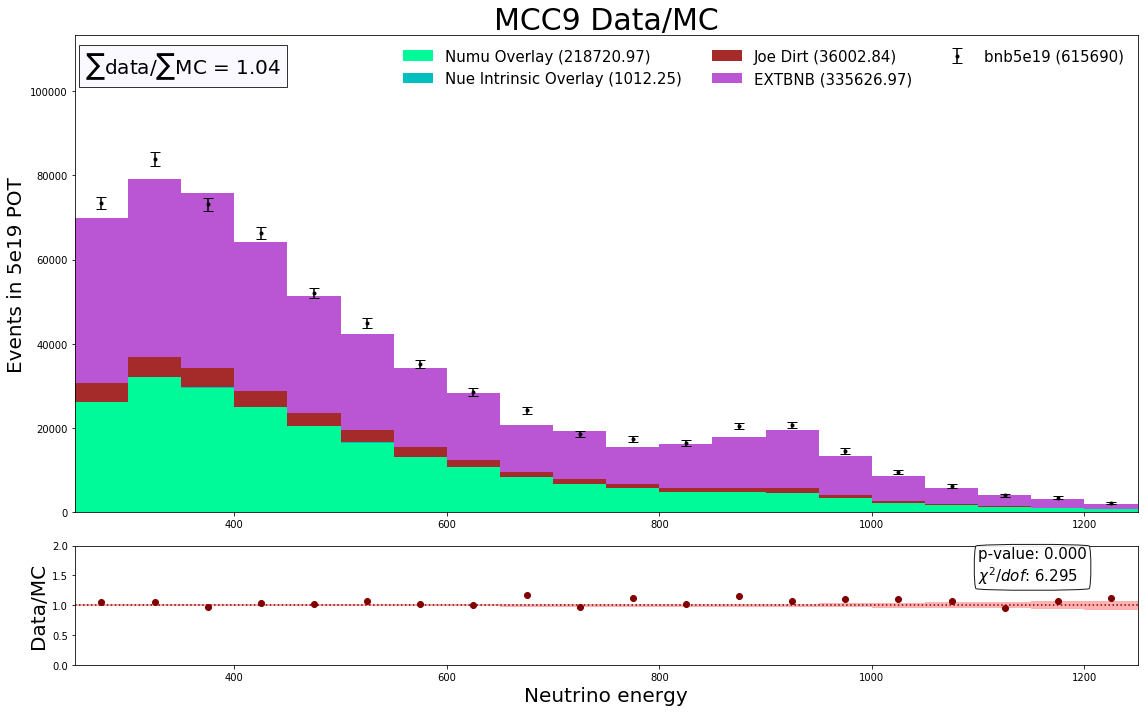

In [8]:
var_numu = df_numu_presel['Enu_1m1p'].values
var_nue = df_nue_presel['Enu_1m1p'].values
var_ext = df_ext_presel['Enu_1m1p'].values
var_data = df_data_presel['Enu_1m1p'].values
var_dirt = df_dirt_presel['Enu_1m1p'].values

fig,ax = plt.subplots(figsize=(16,10))
distplot_wratio(20,(250,1250),[var_numu,var_nue,var_dirt,var_ext],var_data,weights_data_presel,'Neutrino energy')
ax.annotate(r'Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.7,.7), xycoords='axes fraction',fontsize=15)
#ax.annotate('6808 Events in 5e19',xy=(.7,.6), xycoords='axes fraction',fontsize=20)

In [9]:
df_numu_CCQE_presel = df_numu_presel.query("mc_label in ['numu_CCQE']")
df_numu_MEC_presel = df_numu_presel.query("mc_label in ['numu_MEC']")
df_numu_pizero_presel = df_numu_presel.query("mc_label in ['numu_pizero']")
df_numu_piplusminus_presel = df_numu_presel.query("mc_label in ['numu_piplusminus']")
df_bnb_other_presel = df_numu_presel.query("mc_label not in ['nue_offvtx','numu_offvtx','numu_CCQE','numu_MEC','numu_pizero','numu_piplusminus']")
df_bnboverlay_offvtx_presel = df_numu_presel.query("mc_label in ['nue_offvtx','numu_offvtx']")

df_nue_CC_presel = df_nue_presel.query("mc_label not in ['nue_offvtx']")
df_nue_offvtx_presel = df_nue_presel.query("mc_label in ['nue_offvtx']")

weights_bnb_offvtx_presel = np.concatenate((CV(df_bnboverlay_offvtx_presel)*NUMU_SCALE,CV(df_nue_offvtx_presel)*NUE_SCALE))
weights_numu_CCQE_presel = CV(df_numu_CCQE_presel)*NUMU_SCALE
weights_numu_MEC_presel = CV(df_numu_MEC_presel)*NUMU_SCALE
weights_numu_pizero_presel = CV(df_numu_pizero_presel)*NUMU_SCALE
weights_numu_piplusminus_presel = CV(df_numu_piplusminus_presel)*NUMU_SCALE
weights_bnb_other_presel = CV(df_bnb_other_presel)*NUMU_SCALE
weights_nue_CC_presel = CV(df_nue_CC_presel)*NUE_SCALE
weights_ext_presel = np.ones(len(df_ext_presel))*EXT_SCALE
weights_data_presel = np.ones(len(df_data_presel))*DATA_SCALE
weights_dirt_presel = CV(df_dirt_presel)*DIRT_SCALE

a_weights = [weights_numu_CCQE_presel,weights_numu_MEC_presel,weights_numu_pizero_presel,weights_numu_piplusminus_presel,weights_bnb_other_presel,weights_bnb_offvtx_presel,weights_nue_CC_presel,weights_dirt_presel,weights_ext_presel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,DIRT_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'BNB Other','BNB Off Vertex',r'$\nu_e$ Intrinsic Overlay','Dirt','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','peru','fuchsia']

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


Events: 643080.0
MC:  618299.5227391925
Max Bin ct (data): 41190.0
Min Bin ct (data): 0.0


Text(0.65, 0.7, 'Fiducial, Two-Track,and \nContainment Cuts Applied')

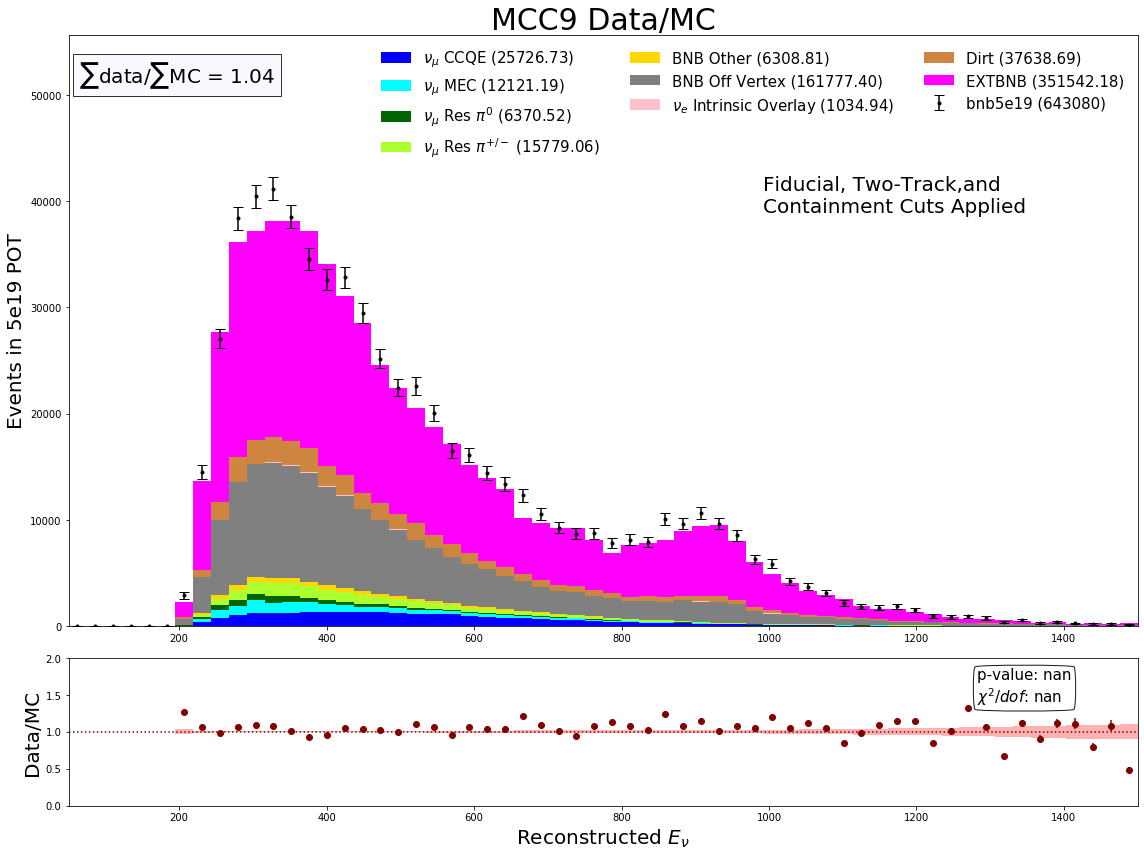

In [10]:
vartest = 'Enu_1m1p'
varname = r'Reconstructed $E_\nu$'
myrange = (50,1500)
nbins = 60

var_offvtx = df_bnb_offvtx_presel[vartest].values
var_ccqe = df_numu_CCQE_presel[vartest].values
var_mec = df_numu_MEC_presel[vartest].values
var_pizero = df_numu_pizero_presel[vartest].values
var_piplusminus = df_numu_piplusminus_presel[vartest].values
var_other = df_bnb_other_presel[vartest].values
var_nue = df_nue_CC_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

Events: 642210.0
MC:  616922.9994941714
Max Bin ct (data): 74610.0
Min Bin ct (data): 480.0


Text(0.65, 0.7, 'Fiducial, Two-Track,and \nContainment Cuts Applied')

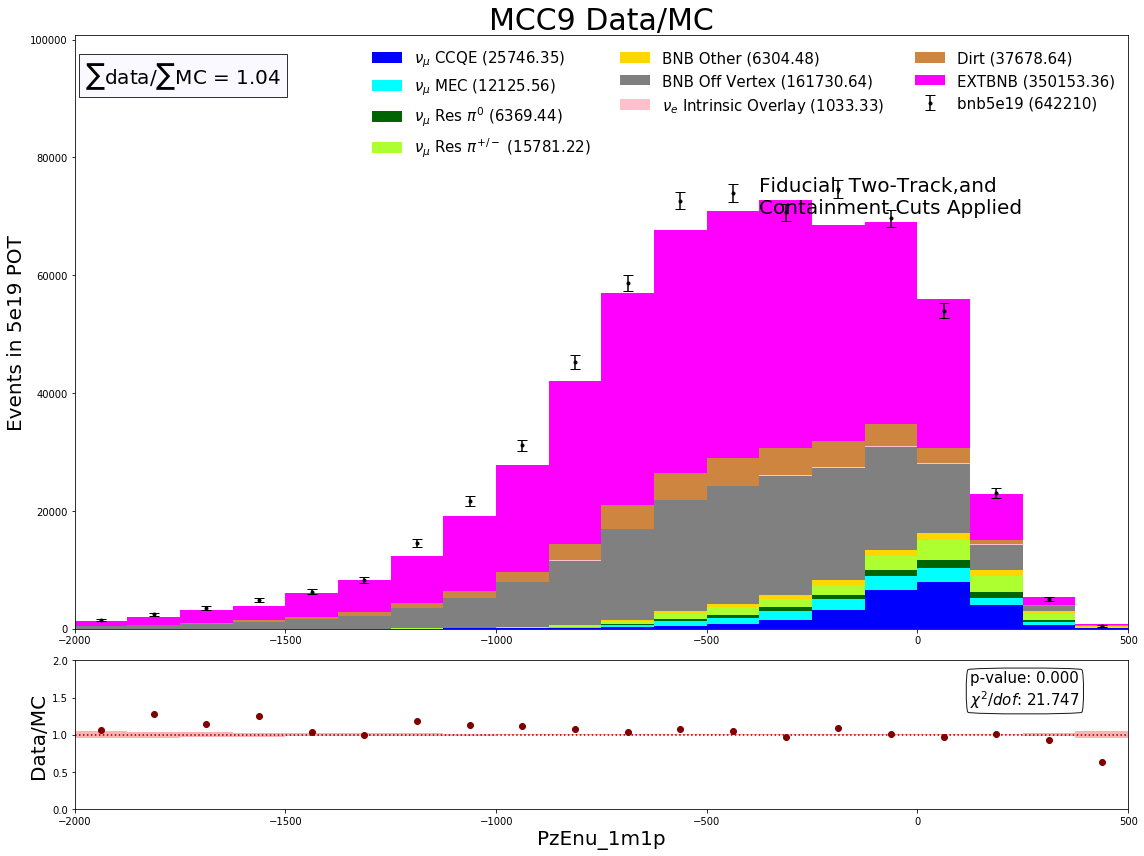

In [82]:
vartest = 'PzEnu_1m1p'
varname = vartest
myrange = (-2000,500)
nbins = 20
yscale = 2e3

var_offvtx = df_bnb_offvtx_presel[vartest].values
var_ccqe = df_numu_CCQE_presel[vartest].values
var_mec = df_numu_MEC_presel[vartest].values
var_pizero = df_numu_pizero_presel[vartest].values
var_piplusminus = df_numu_piplusminus_presel[vartest].values
var_other = df_bnb_other_presel[vartest].values
var_nue = df_nue_CC_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

Events: 21448.0
MC:  20619.663187191356
Max Bin ct (data): 801.0
Min Bin ct (data): 10.0


Text(0.65, 0.7, 'Fiducial, Two-Track,and \nContainment Cuts Applied')

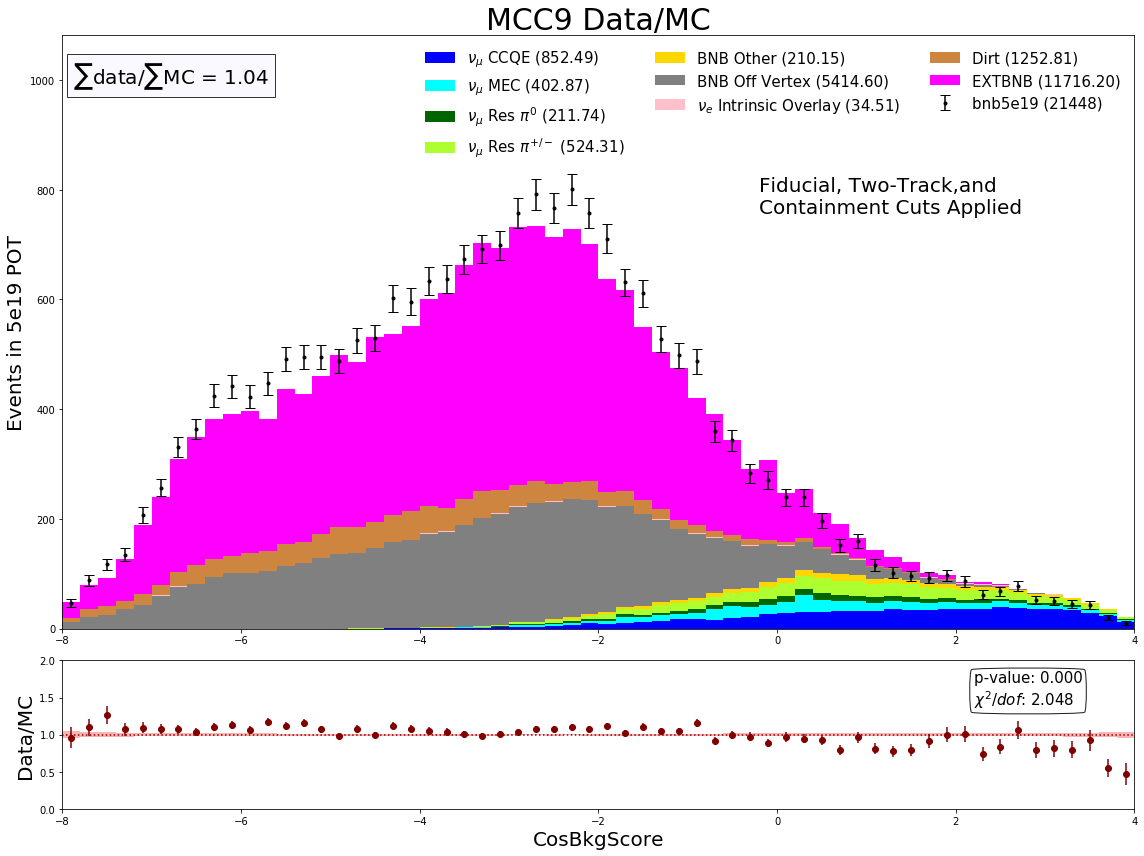

In [61]:
vartest = 'CosBkgScore'
varname = vartest
myrange = (-8,4)
nbins = 60
yscale = 2e3

var_offvtx = df_bnb_offvtx_presel[vartest].values
var_ccqe = df_numu_CCQE_presel[vartest].values
var_mec = df_numu_MEC_presel[vartest].values
var_pizero = df_numu_pizero_presel[vartest].values
var_piplusminus = df_numu_piplusminus_presel[vartest].values
var_other = df_bnb_other_presel[vartest].values
var_nue = df_nue_CC_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

Events: 21040.0
MC:  20259.77017245742
Max Bin ct (data): 1881.0
Min Bin ct (data): 40.0


Text(0.65, 0.7, 'Fiducial, Two-Track,and \nContainment Cuts Applied')

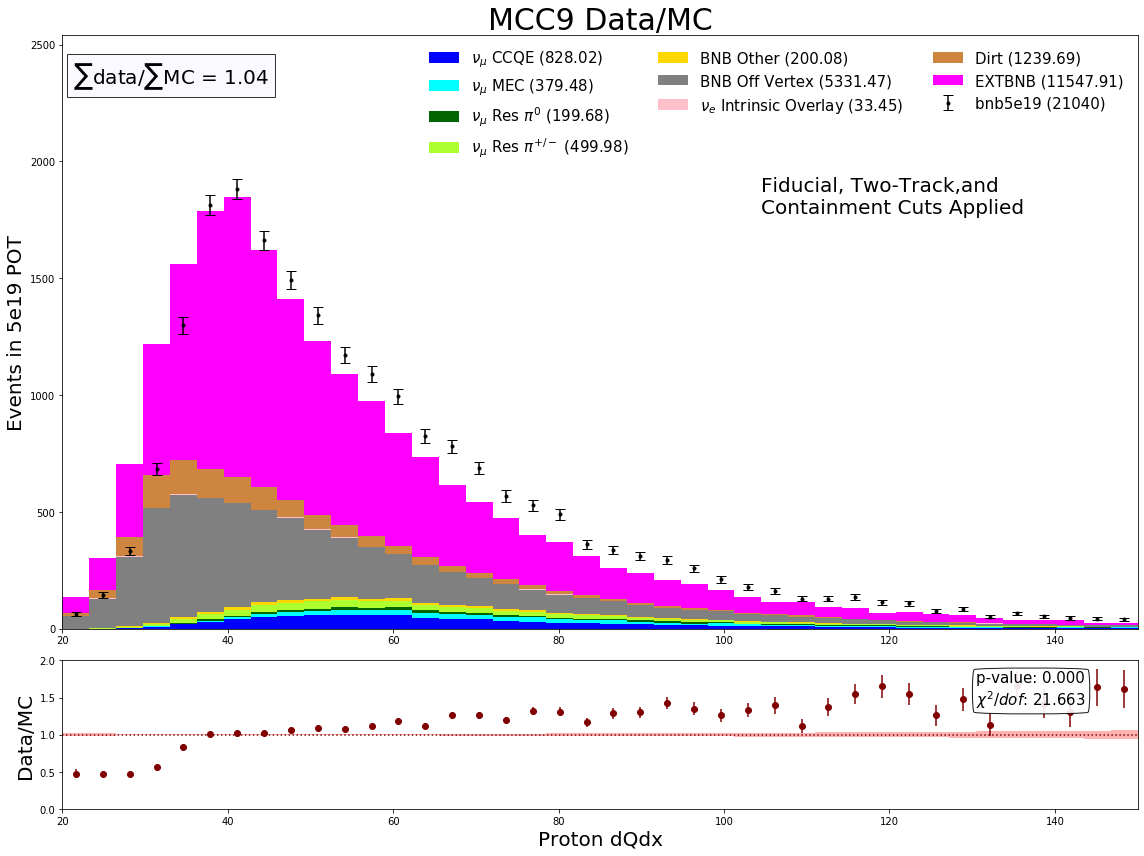

In [59]:
vartest = 'Proton_dQdx'
varname = 'Proton dQdx'
myrange = (20,150)
nbins = 40
yscale = 2.5e3

var_offvtx = df_bnb_offvtx_presel[vartest].values
var_ccqe = df_numu_CCQE_presel[vartest].values
var_mec = df_numu_MEC_presel[vartest].values
var_pizero = df_numu_pizero_presel[vartest].values
var_piplusminus = df_numu_piplusminus_presel[vartest].values
var_other = df_bnb_other_presel[vartest].values
var_nue = df_nue_CC_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

Events: 21498.0
MC:  20665.583198512973
Max Bin ct (data): 2818.0
Min Bin ct (data): 0.0


/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


Text(0.65, 0.7, 'Fiducial, Two-Track,and \nContainment Cuts Applied')

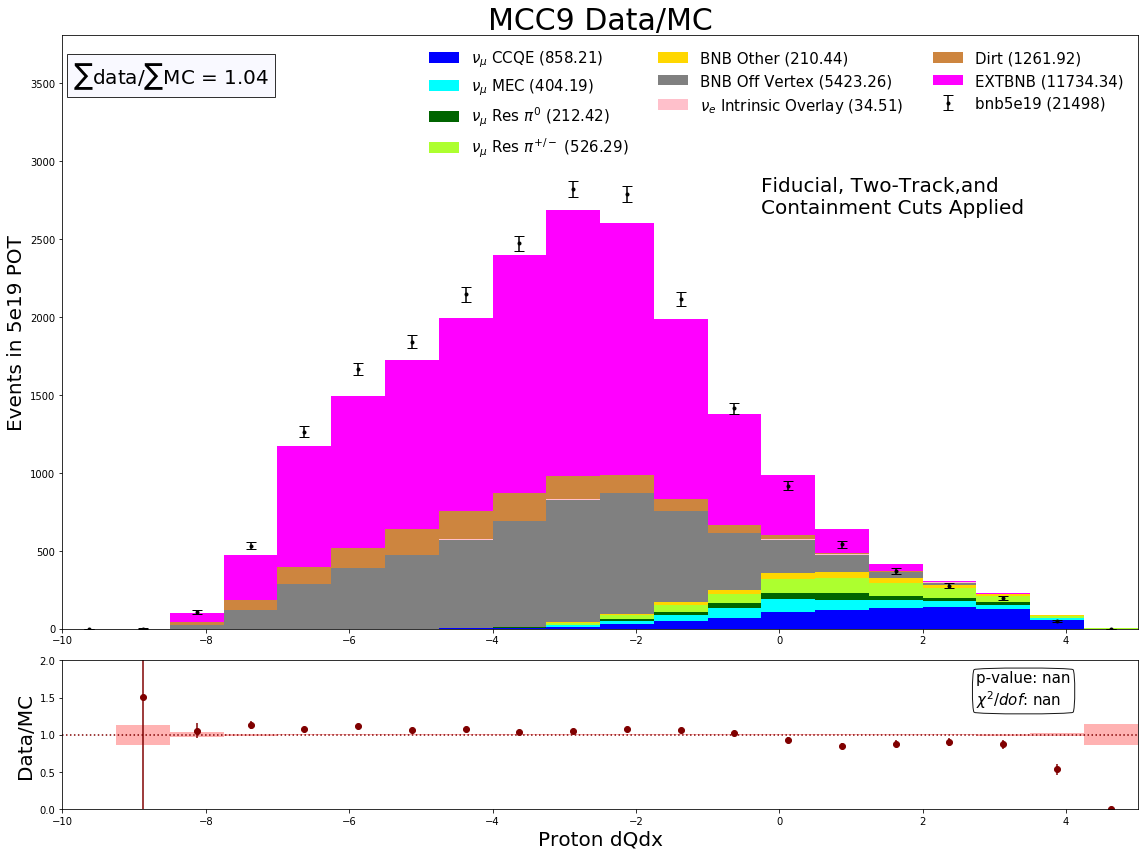

In [21]:
vartest = 'CosBkgScore'
varname = varname
myrange = (-10,5)
nbins = 20
yscale = 2e3

var_offvtx = df_bnb_offvtx_presel[vartest].values
var_ccqe = df_numu_CCQE_presel[vartest].values
var_mec = df_numu_MEC_presel[vartest].values
var_pizero = df_numu_pizero_presel[vartest].values
var_piplusminus = df_numu_piplusminus_presel[vartest].values
var_other = df_bnb_other_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(16,12))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.65,.7), xycoords='axes fraction',fontsize=20)

# Apply Selection

In [ ]:
# We're doing things different now! Load up the weights themselves.
with open('/home/dcianci/Physics/1e1p/1mu1pSelection/bdtweights_1mu1p_sparsenet_vd3.pickle','rb') as handle: cosmicBDT,nubkgBDT = pickle.load(handle)          # Load BDT weights for 1mu1p background differentiation

vars_vd3B = ['Eta','ChargeNearTrunk','OpenAngB_1m1p','PTB_1m1p','AlphaTB_1m1p','BjXB_1m1p','BjYB_1m1p','SphB_1m1p','PzEnu_1m1p','Q0_1m1p','Q3_1m1p','ThetasB_1m1p','PhisB_1m1p','PTRat_1m1p','LongTrackLen']
vars_vd3 = ['Eta','ChargeNearTrunk','OpenAng','PT_1m1p','AlphaT_1m1p','BjX_1m1p','BjY_1m1p','Sph_1m1p','PzEnu_1m1p','Q0_1m1p','Q3_1m1p','Thetas','Phis','PTRat_1m1p','LongTrackLen']
vars_vd4 = ['Eta','ChargeNearTrunk','OpenAng','PT_1m1p','AlphaT_1m1p','BjX_1m1p','BjY_1m1p','Sph_1m1p','PzEnu_1m1p','Q0_1m1p','Q3_1m1p','Thetas','Phis','PTRat_1m1p','LongTrackLen','TotPE','MaxPEFrac']


vars_cos_vd0 = ['ChargeNearTrunk','OpenAng','PzEnu_1m1p','Thetas','Sph_1m1p','Lepton_PhiReco','Proton_PhiReco','LongTrackLen']

myvars = vars_vd3B

In [ ]:
scorename = 'CosBkgScore'

df_offvtx_numu_presel.insert(0,scorename,cosmicBDT.predict(df_offvtx_numu_presel[myvars].values.tolist(),output_margin=True))
df_CCQE_numu_presel.insert(0,scorename,cosmicBDT.predict(df_CCQE_numu_presel[myvars].values.tolist(),output_margin=True))
df_MEC_numu_presel.insert(0,scorename,cosmicBDT.predict(df_MEC_numu_presel[myvars].values.tolist(),output_margin=True))
df_pizero_numu_presel.insert(0,scorename,cosmicBDT.predict(df_pizero_numu_presel[myvars].values.tolist(),output_margin=True))
df_piplusminus_numu_presel.insert(0,scorename,cosmicBDT.predict(df_piplusminus_numu_presel[myvars].values.tolist(),output_margin=True))
df_other_numu_presel.insert(0,scorename,cosmicBDT.predict(df_other_numu_presel[myvars].values.tolist(),output_margin=True))
df_ext_presel.insert(0,scorename,cosmicBDT.predict(df_ext_presel[myvars].values.tolist(),output_margin=True))
df_data_presel.insert(0,scorename,cosmicBDT.predict(df_data_presel[myvars].values.tolist(),output_margin=True))
df_nue_presel.insert(0,scorename,cosmicBDT.predict(df_nue_presel[myvars].values.tolist(),output_margin=True))
df_numu_presel.insert(0,scorename,cosmicBDT.predict(df_numu_presel[myvars].values.tolist(),output_margin=True))
df_dirt_presel.insert(0,scorename,cosmicBDT.predict(df_dirt_presel[myvars].values.tolist(),output_margin=True))

In [ ]:
df_offvtx_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_offvtx_numu_presel[myvars].values.tolist(),output_margin=True))
df_CCQE_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_CCQE_numu_presel[myvars].values.tolist(),output_margin=True))
df_MEC_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_MEC_numu_presel[myvars].values.tolist(),output_margin=True))
df_pizero_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_pizero_numu_presel[myvars].values.tolist(),output_margin=True))
df_piplusminus_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_piplusminus_numu_presel[myvars].values.tolist(),output_margin=True))
df_other_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_other_numu_presel[myvars].values.tolist(),output_margin=True))
df_ext_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_ext_presel[myvars].values.tolist(),output_margin=True))
df_data_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_data_presel[myvars].values.tolist(),output_margin=True))
df_nue_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_nue_presel[myvars].values.tolist(),output_margin=True))
df_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_numu_presel[myvars].values.tolist(),output_margin=True))
df_dirt_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_dirt_presel[myvars].values.tolist(),output_margin=True))

In [83]:
#Plot bdt variables

nuquery = 'NTracks ==2'

cosbkg_signal = df_CCQE_numu_presel.query(nuquery)['CosBkgScore'].values
cosbkg_bkg = df_ext_presel.query(nuquery)['CosBkgScore'].values.tolist() + df_offvtx_numu_presel.query(nuquery)['CosBkgScore'].values.tolist()

fig,ax = plt.subplots(figsize=(13,9))
fig.patch.set_alpha(1)
nbins = 40
myrange = (-10,10)

plt.hist(cosbkg_signal,nbins,range=myrange,color='red',alpha=.4,density=True,label=r'$\nu_\mu$ CCQE')
plt.hist(cosbkg_bkg,nbins,range=myrange,color='grey',alpha=.6,density=True,label='Cosmic Background')
ax.set_xlabel('Cosmic Bkg Score',fontsize=20)
ax.set_ylabel('Area Normalized Units',fontsize=15)

#ax.axvline(4,c='salmon')
#plt.fill_between((-14,4),(0,0),(10,10),hatch='X',facecolor='None',edgecolor='pink',alpha=1)
#ax.set_ylim(0,.20)
ax.set_xlim(myrange)
#ax.annotate('Cut CosBkgScore < 0\nReject 98.9% Bkg\nRetain 80.10% Sig',xy=(.72,.65), xycoords='axes fraction',fontsize=18)


plt.legend(fontsize=25,frameon=False)

NameError: name 'df_CCQE_numu_presel' is not defined

In [84]:
nubkg_signal = df_CCQE_numu_presel.query(cosquery)['NuBkgScore'].values
nubkg_nubkg = df_MEC_numu_presel.query(cosquery)['NuBkgScore'].values.tolist() + df_piplusminus_numu_presel.query(cosquery)['NuBkgScore'].values.tolist() + df_pizero_numu_presel.query(cosquery)['NuBkgScore'].values.tolist() +  df_other_numu_presel.query(cosquery)['NuBkgScore'].values.tolist()
nubkg_cosbkg = df_ext_presel.query(nuquery)['NuBkgScore'].values.tolist() + df_offvtx_numu_presel.query(nuquery)['NuBkgScore'].values.tolist()

cosbkg_signal = df_CCQE_numu_presel.query(cosquery)['CosBkgScore'].values
cosbkg_nubkg = df_MEC_numu_presel.query(cosquery)['CosBkgScore'].values.tolist() + df_piplusminus_numu_presel.query(cosquery)['CosBkgScore'].values.tolist() + df_pizero_numu_presel.query(cosquery)['CosBkgScore'].values.tolist() +  df_other_numu_presel.query(cosquery)['CosBkgScore'].values.tolist()
cosbkg_cosbkg = df_ext_presel.query(nuquery)['CosBkgScore'].values.tolist() + df_offvtx_numu_presel.query(nuquery)['CosBkgScore'].values.tolist()


fig,ax = plt.subplots(figsize=(13,9))
fig.patch.set_alpha(1)

ax.set_xlabel('NuBkg Score',fontsize=20)
ax.set_ylabel('CosmicBkg Score',fontsize=20)


plt.scatter(nubkg_cosbkg,cosbkg_cosbkg,color='palegreen',alpha=.2)
plt.scatter(nubkg_nubkg,cosbkg_nubkg,color='powderblue',alpha=.2)
plt.scatter(nubkg_signal,cosbkg_signal,color='tomato',alpha=.2)
sns.kdeplot(nubkg_cosbkg,cosbkg_cosbkg,label='Ext Bkg',color='green',cmap='Greens')#,cmap="Greens", shade=True, bw=.15)
sns.kdeplot(nubkg_nubkg,cosbkg_nubkg,label='Nu Bkg',color='blue',cmap='Blues')#,cmap="Greens", shade=True, bw=.15)
sns.kdeplot(nubkg_signal,cosbkg_signal,color='red',cmap='Reds',label='Signal')#,cmap="Reds", shade=True, bw=.15)


plt.legend(fontsize=20,loc='lower right')


NameError: name 'df_CCQE_numu_presel' is not defined

In [ ]:
vartest = 'NuBkgScore'
var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(40,(-8,8),[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,vartest)
#ax0.annotate('Bump Cut',xy=(.72,.65), xycoords='axes fraction',fontsize=18)

In [85]:
# Now, let's apply cuts.
augcuts = '(NuBkgScore > 2 and CosBkgScore > 0)'
loosecuts = '(NuBkgScore > 0 and CosBkgScore > 0)'
specialcuts = augcuts + ' and Zreco < 700 and Zreco > 500 and Proton_dQdx > 83'
phicuts = augcuts + ' and Proton_PhiReco  > -1 and eta < .5 and Proton_dQdx < 90'
bumpcuts = augcuts + ' and Proton_dQdx < 90'
isolatebump = augcuts + ' and Proton_dQdx > 90 and Proton_dQdx  < 110'
isolatebad = augcuts + ' and  Proton_dQdx > 60'
isolatenaughty = augcuts + ' and BDTprob == -1'
bestcut = 'NuBkgScore > 0 and CosBkgScore > 2 and BDTprob != -1'
nocuts = 'good==1'


testcut = 'CosBkgScore > 2'

s_cuts = testcut # and .9 > sin(Lepton_PhiReco) > -.9'# and Proton_dQdx < 90'# and (Proton_dQdx < 90 or Proton_dQdx  > 110)'

s_anno = 'Fiducial, Two-Track,and \nContainment Precuts;\nCosBkgScore > 2\nNuBkgScore > 0'

s_ano_simple_w = wrap('Precuts and '+s_cuts,28)
s_ano_simple = '' 
for ln in s_ano_simple_w:
    s_ano_simple += ln + '\n'

In [86]:
df_bnb_offvtx_sel = df_bnb_offvtx_presel.query(s_cuts) 
df_numu_CCQE_sel = df_numu_CCQE_presel.query(s_cuts) 
df_numu_MEC_sel = df_numu_MEC_presel.query(s_cuts) 
df_numu_pizero_sel = df_numu_pizero_presel.query(s_cuts) 
df_numu_piplusminus_sel = df_numu_piplusminus_presel.query(s_cuts) 
df_bnb_other_sel = df_bnb_other_presel.query(s_cuts) 
df_nue_sel = df_nue_presel.query(s_cuts)
df_ext_sel = df_ext_presel.query(s_cuts)
df_data_sel = df_data_presel.query(s_cuts)
df_dirt_sel = df_dirt_presel.query(s_cuts) 

weights_bnb_offvtx_sel = CV(df_bnb_offvtx_sel)*NUMU_SCALE
weights_numu_CCQE_sel = CV(df_numu_CCQE_sel)*NUMU_SCALE
weights_numu_MEC_sel = CV(df_numu_MEC_sel)*NUMU_SCALE
weights_numu_pizero_sel = CV(df_numu_pizero_sel)*NUMU_SCALE
weights_numu_piplusminus_sel = CV(df_numu_piplusminus_sel)*NUMU_SCALE
weights_bnb_other_sel = CV(df_bnb_other_sel)*NUMU_SCALE
weights_nue_sel = CV(df_nue_sel)*NUE_SCALE
weights_ext_sel = np.ones(len(df_ext_sel))*EXT_SCALE
weights_data_sel = np.ones(len(df_data_sel))*DATA_SCALE
weights_dirt_sel = CV(df_dirt_sel)*DIRT_SCALE

errlabel = 'Flux Sys Only'

a_weights = [weights_numu_CCQE_sel,weights_numu_MEC_sel,weights_numu_pizero_sel,weights_numu_piplusminus_sel,weights_bnb_other_sel,weights_bnb_offvtx_sel,weights_nue_sel,weights_dirt_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,DIRT_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'BNB Other','BNB Off Vertex',r'$\nu_e$ Intrinsic Overlay','Dirt','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','peru','fuchsia']

Events: 15540.0
MC:  18620.48761373017
Max Bin ct (data): 2370.0
Min Bin ct (data): 0.0


Text(0.65, 0.65, 'Precuts and CosBkgScore > 2\n')

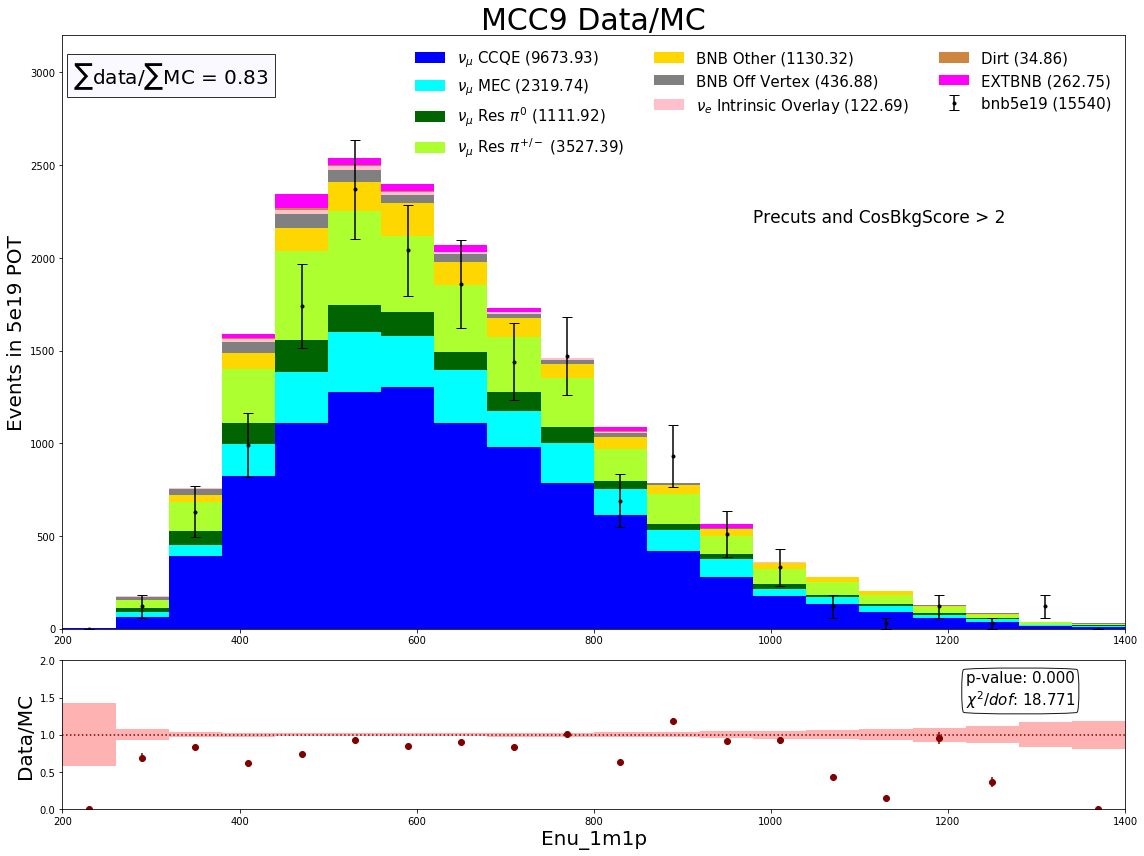

In [87]:
vartest = 'Enu_1m1p'
varname = vartest
myrange = (200,1400)
nbins = 20
#cov = np.genfromtxt('../data/CovMatrices/covar_postsel_set1__nu_energy_reco.txt',delimiter=',')
legpos = 0

var_offvtx = df_bnb_offvtx_sel[vartest].values
var_ccqe = df_numu_CCQE_sel[vartest].values
var_mec = df_numu_MEC_sel[vartest].values
var_pizero = df_numu_pizero_sel[vartest].values
var_piplusminus = df_numu_piplusminus_sel[vartest].values
var_other = df_bnb_other_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(16,12))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname)
ax0.annotate(s_ano_simple,xy=(.65,.65), xycoords='axes fraction',fontsize=17)

Events: 517.0
MC:  617.1740260511826
Max Bin ct (data): 71.0
Min Bin ct (data): 0.0


Text(0.65, 0.65, 'Precuts and CosBkgScore > 2\n')

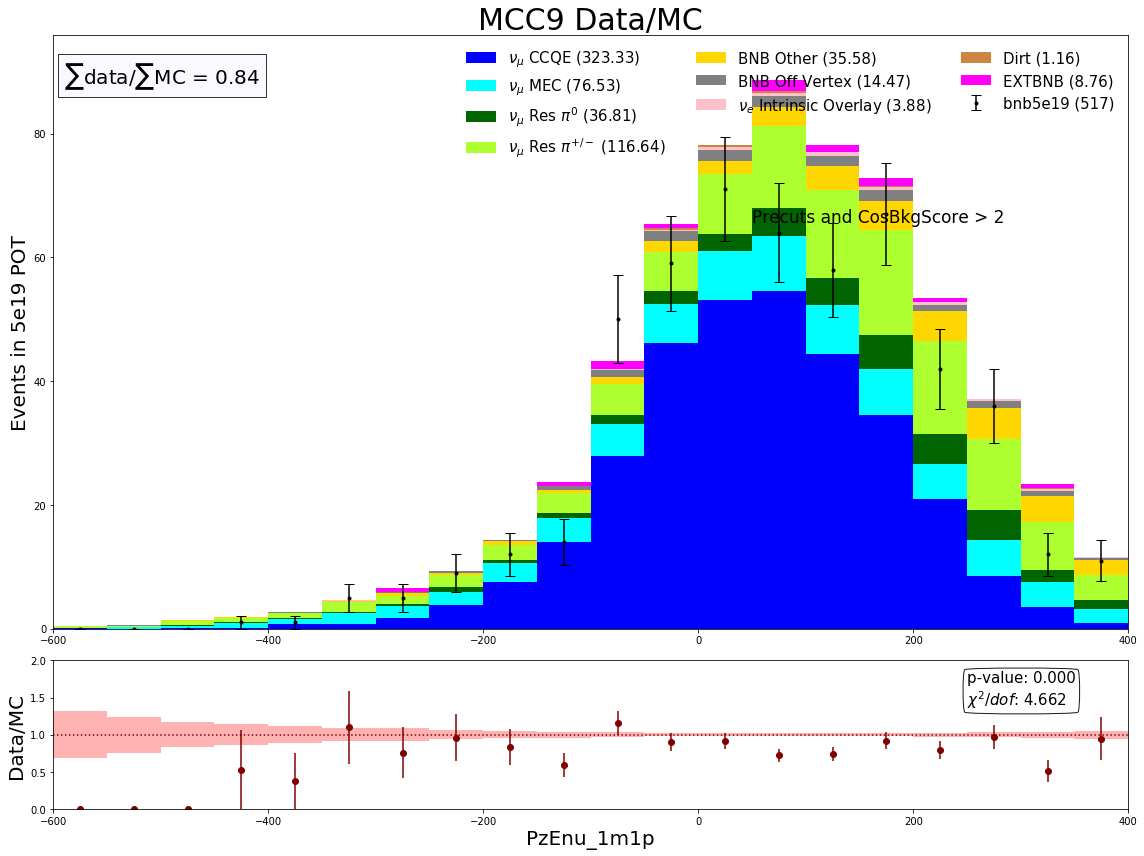

In [65]:
vartest = 'PzEnu_1m1p'
varname = vartest
myrange = (-600,400)
nbins = 20
#cov = np.genfromtxt('../data/CovMatrices/covar_postsel_set1__nu_energy_reco.txt',delimiter=',')
legpos = 0

var_offvtx = df_bnb_offvtx_sel[vartest].values
var_ccqe = df_numu_CCQE_sel[vartest].values
var_mec = df_numu_MEC_sel[vartest].values
var_pizero = df_numu_pizero_sel[vartest].values
var_piplusminus = df_numu_piplusminus_sel[vartest].values
var_other = df_bnb_other_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(16,12))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname)
ax0.annotate(s_ano_simple,xy=(.65,.65), xycoords='axes fraction',fontsize=17)

Events: 519.0
MC:  612.4426043309619
Max Bin ct (data): 53.0
Min Bin ct (data): 0.0


Text(0.65, 0.65, 'Precuts and CosBkgScore > 2\n')

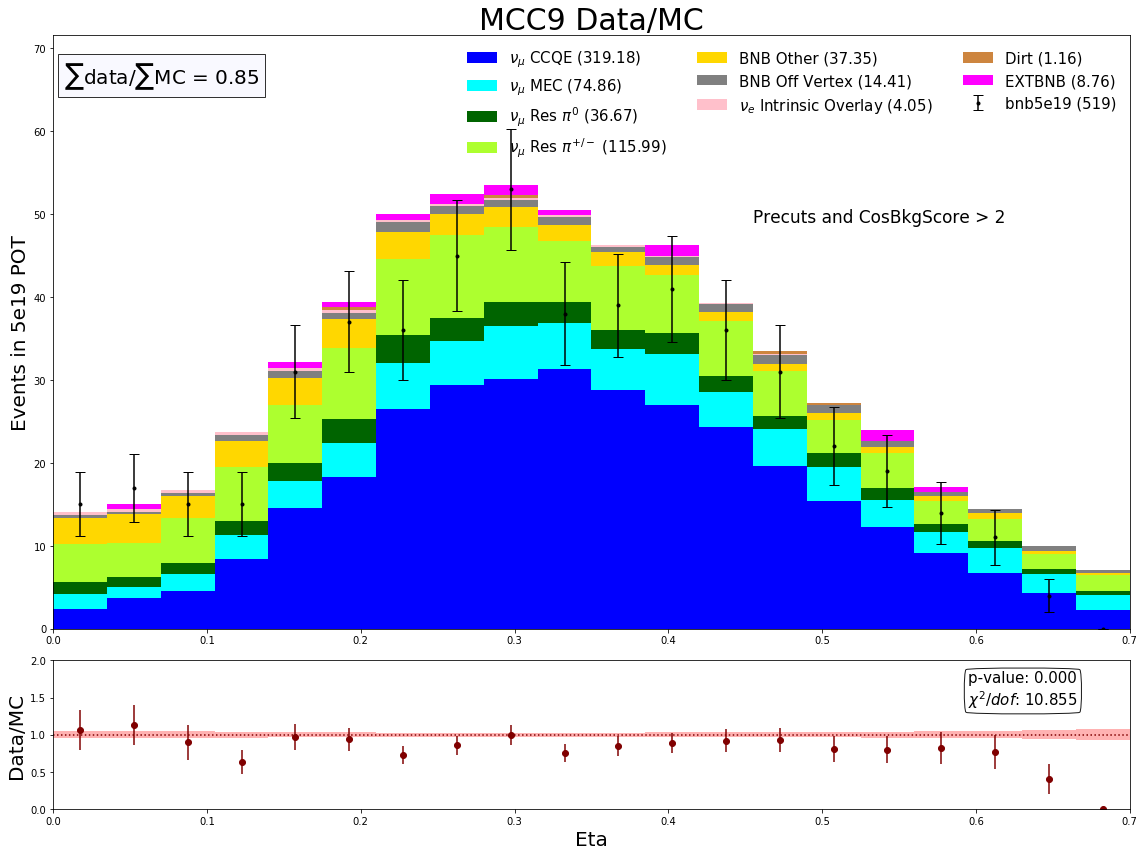

In [66]:
vartest = 'Eta'
varname = vartest
myrange = (0,.7)
nbins = 20
#cov = np.genfromtxt('../data/CovMatrices/covar_postsel_set1__nu_energy_reco.txt',delimiter=',')
legpos = 0

var_offvtx = df_bnb_offvtx_sel[vartest].values
var_ccqe = df_numu_CCQE_sel[vartest].values
var_mec = df_numu_MEC_sel[vartest].values
var_pizero = df_numu_pizero_sel[vartest].values
var_piplusminus = df_numu_piplusminus_sel[vartest].values
var_other = df_bnb_other_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(16,12))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname)
ax0.annotate(s_ano_simple,xy=(.65,.65), xycoords='axes fraction',fontsize=17)

Events: 516.0
MC:  612.8494189276714
Max Bin ct (data): 100.0
Min Bin ct (data): 0.0


Text(0.65, 0.65, 'Precuts and CosBkgScore > 2\n')

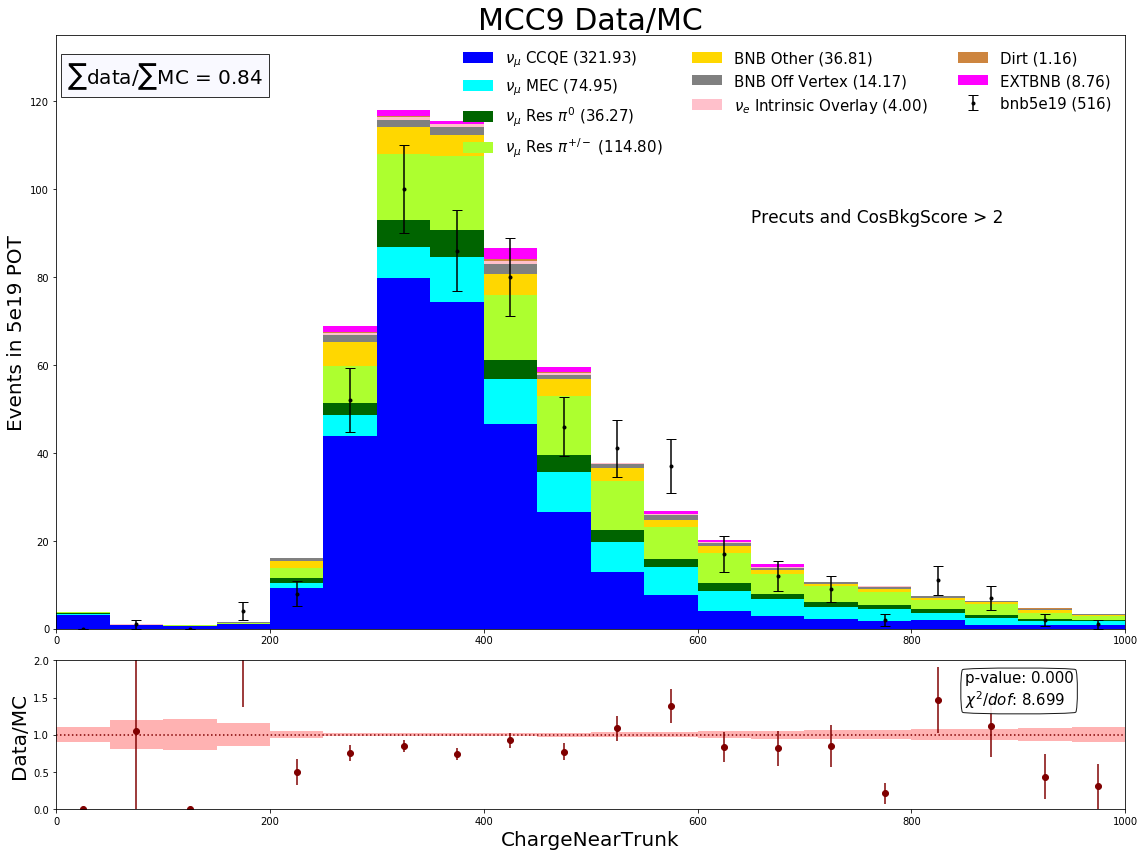

In [70]:
vartest = 'ChargeNearTrunk'
varname = vartest
myrange = (0,1000)
nbins = 20
#cov = np.genfromtxt('../data/CovMatrices/covar_postsel_set1__nu_energy_reco.txt',delimiter=',')
legpos = 0

var_offvtx = df_bnb_offvtx_sel[vartest].values
var_ccqe = df_numu_CCQE_sel[vartest].values
var_mec = df_numu_MEC_sel[vartest].values
var_pizero = df_numu_pizero_sel[vartest].values
var_piplusminus = df_numu_piplusminus_sel[vartest].values
var_other = df_bnb_other_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(16,12))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname)
ax0.annotate(s_ano_simple,xy=(.65,.65), xycoords='axes fraction',fontsize=17)

Events: 519.0
MC:  623.0770487814684
Max Bin ct (data): 91.0
Min Bin ct (data): 0.0


/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


Text(0.65, 0.65, 'Precuts and CosBkgScore > 2\n')

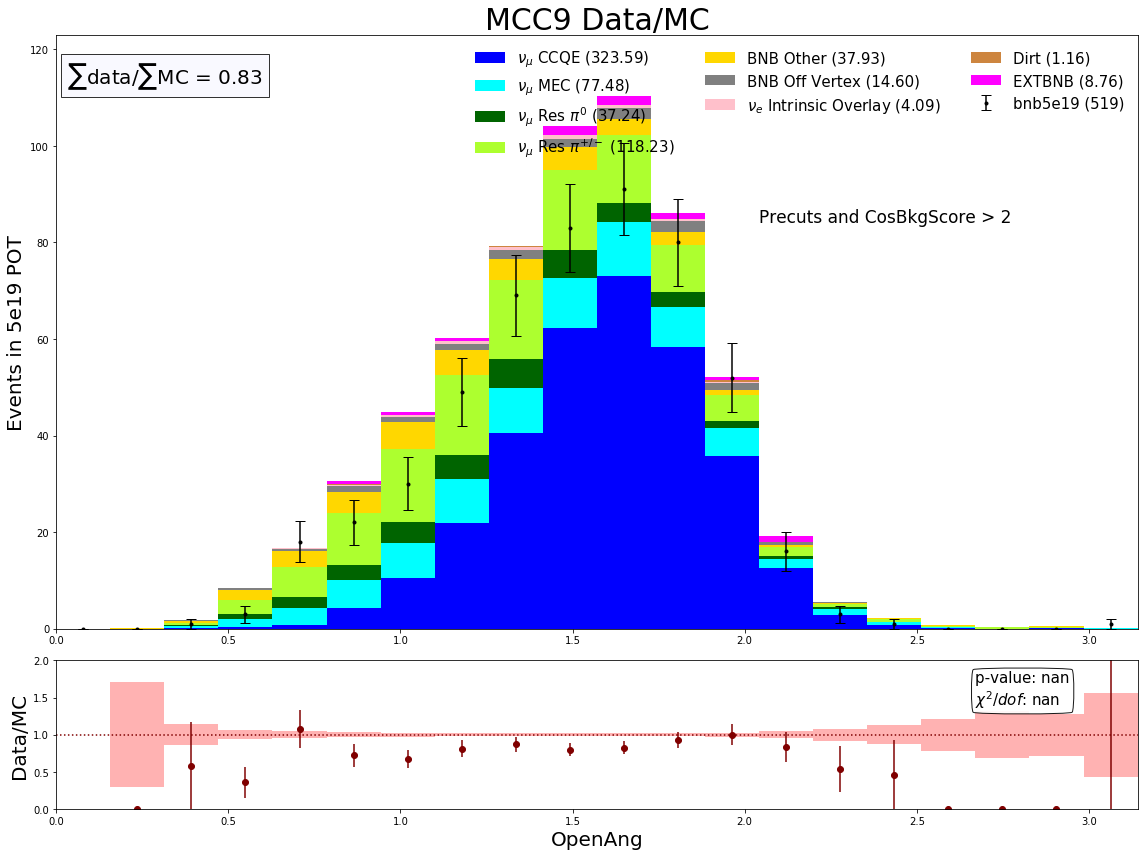

In [71]:
vartest = 'OpenAng'
varname = vartest
myrange = (0,np.pi)
nbins = 20
#cov = np.genfromtxt('../data/CovMatrices/covar_postsel_set1__nu_energy_reco.txt',delimiter=',')
legpos = 0

var_offvtx = df_bnb_offvtx_sel[vartest].values
var_ccqe = df_numu_CCQE_sel[vartest].values
var_mec = df_numu_MEC_sel[vartest].values
var_pizero = df_numu_pizero_sel[vartest].values
var_piplusminus = df_numu_piplusminus_sel[vartest].values
var_other = df_bnb_other_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(16,12))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname)
ax0.annotate(s_ano_simple,xy=(.65,.65), xycoords='axes fraction',fontsize=17)

Events: 519.0
MC:  623.0770487814682
Max Bin ct (data): 37.0
Min Bin ct (data): 16.0


Text(0.65, 0.65, 'Precuts and CosBkgScore > 2\n')

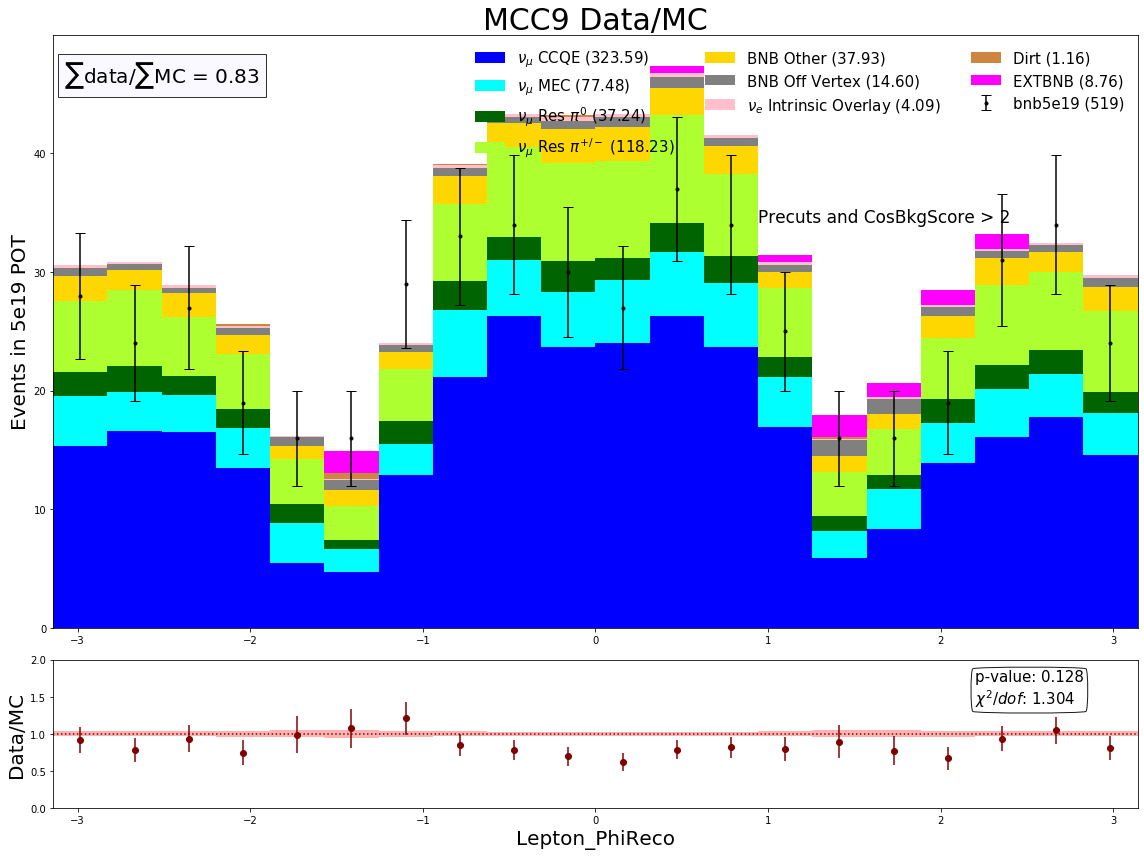

In [73]:
vartest = 'Lepton_PhiReco'
varname = vartest
myrange = (-np.pi,np.pi)
nbins = 20
#cov = np.genfromtxt('../data/CovMatrices/covar_postsel_set1__nu_energy_reco.txt',delimiter=',')
legpos = 0

var_offvtx = df_bnb_offvtx_sel[vartest].values
var_ccqe = df_numu_CCQE_sel[vartest].values
var_mec = df_numu_MEC_sel[vartest].values
var_pizero = df_numu_pizero_sel[vartest].values
var_piplusminus = df_numu_piplusminus_sel[vartest].values
var_other = df_bnb_other_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(16,12))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname)
ax0.annotate(s_ano_simple,xy=(.65,.65), xycoords='axes fraction',fontsize=17)

In [36]:
list(df_offvtx_numu_sel)

NameError: name 'df_offvtx_numu_sel' is not defined

Events: 508.0
MC:  593.1251276228382
Max Bin ct (data): 67.0
Min Bin ct (data): 2.0


Text(0.65, 0.65, 'Precuts and CosBkgScore > 2\n')

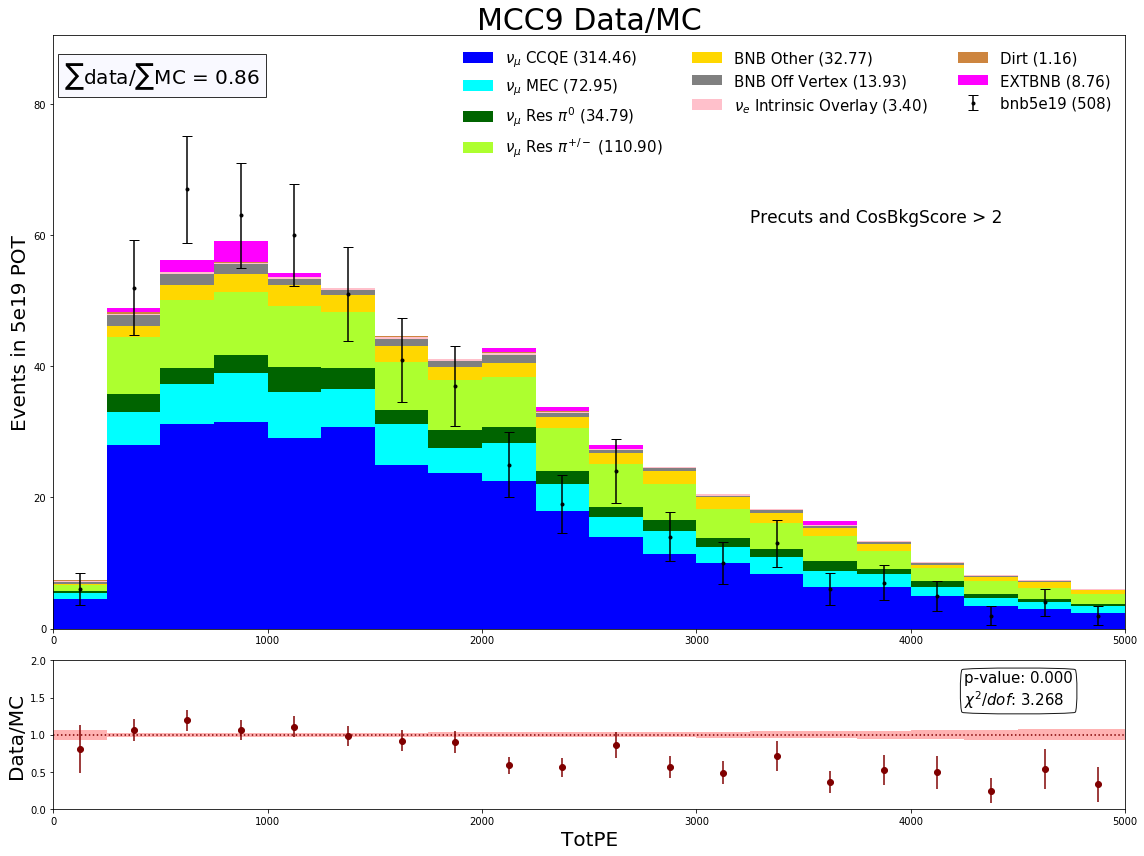

In [77]:
vartest = 'TotPE'
varname = vartest
myrange = (0,5000)
nbins = 20
#cov = np.genfromtxt('../data/CovMatrices/covar_postsel_set1__nu_energy_reco.txt',delimiter=',')
legpos = 0

var_offvtx = df_bnb_offvtx_sel[vartest].values
var_ccqe = df_numu_CCQE_sel[vartest].values
var_mec = df_numu_MEC_sel[vartest].values
var_pizero = df_numu_pizero_sel[vartest].values
var_piplusminus = df_numu_piplusminus_sel[vartest].values
var_other = df_bnb_other_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(16,12))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname)
ax0.annotate(s_ano_simple,xy=(.65,.65), xycoords='axes fraction',fontsize=17)

In [ ]:
data_q0 = df_data_sel['Q0_1m1p'].values
data_q3 = df_data_sel['Q3_1m1p'].values

data_q0 = data_q0[data_q0>=0]
data_q3 = data_q3[data_q3>=0]

ccqe_q0 = df_CCQE_numu_presel['Q0_1m1p'].values
ccqe_q3 = df_CCQE_numu_presel['Q3_1m1p'].values

ccqe_q0 = ccqe_q0[ccqe_q0>=0]
ccqe_q3 = ccqe_q3[ccqe_q3>=0]

fig,ax = plt.subplots(figsize=(9,9))
sns.set_style('ticks')
plt.scatter(ccqe_q0,ccqe_q3,color='lavender',alpha=.9)
plt.scatter(data_q0,data_q3,color='mistyrose',alpha=1)
sns.kdeplot(data_q0,data_q3,label='Selected BNB5e19',color='red',cmap='Reds')#,cmap="Reds", shade=True, bw=.15)
sns.kdeplot(ccqe_q0,ccqe_q3,label='CCQE MC',color='blue',cmap='Blues')#,cmap="Greens", shade=True, bw=.15)

ax.set_xlabel(r'$Q_0$',fontsize=20)
ax.set_ylabel(r'$Q_3$',fontsize=20)
plt.legend(fontsize=20,loc='lower right')
#plt.yscale('log')
#plt.xscale('log')
plt.xlim(0,1000)
plt.ylim(0,1000)

In [ ]:
dataprotonE = df_data_sel['Proton_Edep'].values
datadqdx = df_data_sel['Proton_dQdx'].values

#mcprotone = df_nue_sel.query('scedir_corrected < 5')['Proton_Edep'].values.tolist() + df_numu_sel.query('scedir_corrected < 5')['Proton_Edep'].values.tolist()
#mcdqdx = df_nue_sel.query('scedir_corrected < 5')['Proton_dQdx'].values.tolist() + df_numu_sel.query('scedir_corrected < 5')['Proton_dQdx'].values.tolist()

fig,ax = plt.subplots(figsize=(9,9))
sns.set_style('ticks')
plt.scatter(datadqdx,dataprotonE,color='mistyrose',alpha=1)
plt.scatter(mcdqdx,mcprotone,color='lavender',alpha=.9)
sns.kdeplot(datadqdx,dataprotonE,label='Numu',color='red',cmap='Reds')#,cmap="Reds", shade=True, bw=.15)
#sns.kdeplot(mcdqdx,mcprotone,label='Nue',color='blue',cmap='Blues')#,cmap="Greens", shade=True, bw=.15)

ax.set_xlabel('proton dqdx')
ax.set_ylabel('proton energy')
plt.legend(fontsize=20,loc='lower right')
plt.title('True vertex within 5cm')
plt.yscale('log')
plt.xscale('log')
plt.xlim(20,1000)
plt.ylim(60,1000)

In [ ]:
print(mcdqdx)

In [ ]:
vary = df_data_sel['Xreco'].values
varz = df_data_sel['Zreco'].values

fig,ax = plt.subplots(figsize=(12,4))
datahist = plt.hist2d(varz,vary,(20,9),((0,1036),(0,232)),vmax=3)

#plt.hist2d(x, y, bins=40, norm=LogNorm())
plt.colorbar()
plt.title('bnb5e19 Data')
ax.set_ylabel('X Reco',fontsize=20)
ax.set_xlabel('Z Reco',fontsize=20)

vary = df_nue_sel['Xreco'].values.tolist() + df_numu_sel['Xreco'].values.tolist() + df_ext_sel['Xreco'].values.tolist()
varz = df_nue_sel['Zreco'].values.tolist() + df_numu_sel['Zreco'].values.tolist() + df_ext_sel['Zreco'].values.tolist()

fig,ax = plt.subplots(figsize=(12,4))
mchist = plt.hist2d(varz,vary,(20,9),((0,1036),(0,232)),weights =weights_nue_sel.tolist()+weights_numu_sel.tolist()+weights_ext_sel.tolist(),vmax=3)

#plt.hist2d(x, y, bins=40, norm=LogNorm())
plt.colorbar()
plt.title('MC+ExtBNB')
ax.set_ylabel('X Reco',fontsize=20)
ax.set_xlabel('Z Reco',fontsize=20)


fig,ax = plt.subplots(figsize=(12,4))
plt.imshow(np.transpose(np.flip(datahist[0]-mchist[0],1)),aspect='auto',extent=(0,1036,0,232))
#plt.imshow(np.transpose(datahist[0])-np.transpose(mchist[0]),

plt.colorbar()
plt.title('Data - (MC+ExtBNB)')
ax.set_ylabel('X Reco',fontsize=20)
ax.set_xlabel('Z Reco',fontsize=20)

In [ ]:
df_bump = df_data_presel.query(s_cuts + ' and result!=1')

myvar = 'Proton_dQdx'
myrange = (20,150)
mybins = 18

fig,ax = plt.subplots(figsize=(14,10))
_ = ax.hist(df_bump[myvar],mybins,range=myrange,density=True,alpha=.6)
_ = ax.hist(df_ext_sel[myvar],mybins,range=myrange,density=True,alpha=.3,label='Selected ExtBNB')
ax.set_title('Selected BNB5e19 Events Which Fail Beam Quality Filter',fontsize=20)
ax.set_xlabel('Proton_dQdx',fontsize=15)
ax.set_ylabel('Events',fontsize=15)

plt.legend(fontsize=20)

In [ ]:
myvar = 'Enu_1m1p'
myrange = (200,1250)
mybins = 18

fig,ax = plt.subplots(figsize=(14,10))
_ = ax.hist(df_bump[myvar],mybins,range=myrange,density=True,alpha=.6)
_ = ax.hist(df_ext_sel[myvar],mybins,range=myrange,density=True,alpha=.3,label='Selected ExtBNB')
ax.set_title('Selected BNB5e19 Events Which Fail Beam Quality Filter',fontsize=20)
ax.set_xlabel(myvar,fontsize=15)
ax.set_ylabel('Events',fontsize=15)

plt.legend(fontsize=20)

In [ ]:
myvar = 'Proton_PhiReco'
myrange = (-np.pi,np.pi)
mybins = 18

fig,ax = plt.subplots(figsize=(14,10))
_ = ax.hist(df_bump[myvar],mybins,range=myrange,density=True,alpha=.6)
_ = ax.hist(df_ext_sel[myvar],mybins,range=myrange,density=True,alpha=.3,label='Selected ExtBNB')
ax.set_title('Selected BNB5e19 Events Which Fail Beam Quality Filter',fontsize=20)
ax.set_xlabel(myvar,fontsize=15)
ax.set_ylabel('Events',fontsize=15)

plt.legend(fontsize=20)

In [ ]:
myvar = 'Proton_ThetaReco'
myrange = (-1,1)
mybins = 18

fig,ax = plt.subplots(figsize=(14,10))
_ = ax.hist(df_bump[myvar],mybins,range=myrange,density=True,alpha=.6)
_ = ax.hist(df_ext_sel[myvar],mybins,range=myrange,density=True,alpha=.3,label='Selected ExtBNB')
ax.set_title('Selected BNB5e19 Events Which Fail Beam Quality Filter',fontsize=20)
ax.set_xlabel('Cos(Proton_ThetaReco)',fontsize=15)
ax.set_ylabel('Events',fontsize=15)

plt.legend(fontsize=20)

In [ ]:
myvar = 'Zreco'
myrange = (0,1016)
mybins = 18

fig,ax = plt.subplots(figsize=(14,10))
_ = ax.hist(df_bump[myvar],mybins,range=myrange,density=True,alpha=.6)
_ = ax.hist(df_ext_sel[myvar],mybins,range=myrange,density=True,alpha=.3,label='Selected ExtBNB')
ax.set_title('Selected BNB5e19 Events Which Fail Beam Quality Filter',fontsize=20)
ax.set_xlabel(myvar,fontsize=15)
ax.set_ylabel('Events',fontsize=15)

plt.legend(fontsize=20)

In [ ]:
myvar = 'Eta'
myrange = (0,.6)
mybins = 18

fig,ax = plt.subplots(figsize=(14,10))
_ = ax.hist(df_bump[myvar],mybins,range=myrange,density=True,alpha=.6)
_ = ax.hist(df_ext_sel[myvar],mybins,range=myrange,density=True,alpha=.3,label='Selected ExtBNB')
ax.set_title('Selected BNB5e19 Events Which Fail Beam Quality Filter',fontsize=20)
ax.set_xlabel(myvar,fontsize=15)
ax.set_ylabel('Events',fontsize=15)

plt.legend(fontsize=20)

In [ ]:
myvar = 'ChargeNearTrunk'
myrange = (0,1000)
mybins = 18

fig,ax = plt.subplots(figsize=(14,10))
_ = ax.hist(df_bump[myvar],mybins,range=myrange,density=True,alpha=.6)
_ = ax.hist(df_ext_sel[myvar],mybins,range=myrange,density=True,alpha=.3,label='Selected ExtBNB')
ax.set_title('Selected BNB5e19 Events Which Fail Beam Quality Filter',fontsize=20)
ax.set_xlabel(myvar,fontsize=15)
#ax.set_ylabel('Events',fontsize=15)
plt.legend(fontsize=20)



In [ ]:
myvar = 'OpenAng'
myrange = (0,np.pi)
mybins = 18

fig,ax = plt.subplots(figsize=(14,10))
_ = ax.hist(df_bump[myvar],mybins,range=myrange,density=True,alpha=.6)
_ = ax.hist(df_ext_sel[myvar],mybins,range=myrange,density=True,alpha=.3,label='Selected ExtBNB')
ax.set_title('Selected BNB5e19 Events Which Fail Beam Quality Filter',fontsize=20)
ax.set_xlabel(myvar,fontsize=15)
#ax.set_ylabel('Events',fontsize=15)
plt.legend(fontsize=20)


In [ ]:
#Plot bdt variables

cosquery = 'NTracks == 2'


nubkg_signal = df_CCQE_numu_presel.query(cosquery)['NuBkgScore'].values
nubkg_bkg = df_MEC_numu_presel.query(cosquery)['NuBkgScore'].values.tolist() + df_piplusminus_numu_presel.query(cosquery)['NuBkgScore'].values.tolist() + df_pizero_numu_presel.query(cosquery)['NuBkgScore'].values.tolist() +  df_other_numu_presel.query(cosquery)['NuBkgScore'].values.tolist()



fig,ax = plt.subplots(figsize=(13,9))
fig.patch.set_alpha(1)
nbins = 40
myrange = (-10,10)

plt.hist(nubkg_signal,nbins,range=myrange,color='red',alpha=.4,density=True,label=r'$\nu_\mu$ CCQE')
plt.hist(nubkg_bkg,nbins,range=myrange,color='blue',alpha=.6,density=True,label=r'$\nu_\mu$ non-CCQE')

ax.set_xlabel('Nu Bkg Score',fontsize=20)
ax.set_ylabel('Area Normalized Units',fontsize=15)

ax.axvline(0,c='salmon')
plt.fill_between((-14,0),(0,0),(10,10),hatch='X',facecolor='None',edgecolor='pink',alpha=1)
ax.set_ylim(0,.35)
ax.set_xlim(myrange)
#ax.annotate('Cut NuBkgScore < 0\nReject 93.47% Bkg\nRetain 78.74% Sig',xy=(.72,.65), xycoords='axes fraction',fontsize=18)


plt.legend(fontsize=25,frameon=False)

In [ ]:
myvar = 'Q2_1m1p'
myrange = (0,1000000)
mybins = 18

fig,ax = plt.subplots(figsize=(14,10))
_ = ax.hist(df_bump[myvar],mybins,range=myrange,density=True,alpha=.6)
_ = ax.hist(df_ext_sel[myvar],mybins,range=myrange,density=True,alpha=.3,label='Selected ExtBNB')
ax.set_title('Selected BNB5e19 Events Which Fail Beam Quality Filter',fontsize=20)
ax.set_xlabel(myvar,fontsize=15)
#ax.set_ylabel('Events',fontsize=15)
plt.legend(fontsize=20)


In [ ]:
myvar = 'Q0_1m1p'
myrange = (0,1000)
mybins = 18

fig,ax = plt.subplots(figsize=(14,10))
_ = ax.hist(df_bump[myvar],mybins,range=myrange,density=True,alpha=.6)
_ = ax.hist(df_ext_sel[myvar],mybins,range=myrange,density=True,alpha=.3,label='Selected ExtBNB')
ax.set_title('Selected BNB5e19 Events Which Fail Beam Quality Filter',fontsize=20)
ax.set_xlabel(myvar,fontsize=15)
#ax.set_ylabel('Events',fontsize=15)
plt.legend(fontsize=20)


In [ ]:
myvar = 'Q3_1m1p'
myrange = (0,1000)
mybins = 18

fig,ax = plt.subplots(figsize=(14,10))
_ = ax.hist(df_bump[myvar],mybins,range=myrange,density=True,alpha=.6)
_ = ax.hist(df_ext_sel[myvar],mybins,range=myrange,density=True,alpha=.3,label='Selected ExtBNB')
ax.set_title('Selected BNB5e19 Events Which Fail Beam Quality Filter',fontsize=20)
ax.set_xlabel(myvar,fontsize=15)
#ax.set_ylabel('Events',fontsize=15)
plt.legend(fontsize=20)


In [ ]:
vartest = 'Xreco'
varname = 'X Reco'
myrange = (10,250)
nbins = 40
yscale = .5e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'Yreco'
varname = 'Yreco'
myrange = (-106,106)
nbins = 40
yscale = 5e1

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'Zreco'
varname = 'Zreco'
myrange = (10,1010)
nbins = 40
yscale = 5e1

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'Eta'
varname = r'$\eta$'
myrange = (0,.6)
nbins = 40
yscale = 5e1

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'ChargeNearTrunk'
varname = 'Charge within 5cm of vertex'
myrange = (150,700)
nbins = 30
yscale = 8e1

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'LongTrackLen'
varname = 'Length of longer track'
myrange = (5,325)
nbins = 30
yscale = 6e1

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'ShortTrackLen'
varname = 'Length of shorter track'
myrange = (5,75)
nbins = 30
yscale = 1e2


var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'CCQEEnergyShift_1m1p'
varname = 'Shift in energy to achieve CCQE Consistency'
myrange = (0,4.9)
nbins = 20
yscale = .6e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'OpenAng'
varname = 'Opening Angle'
myrange = (.8,2.8)
nbins = 30
yscale = 7e1

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'OpenAngB_1m1p'
varname = 'Opening Angle *'
myrange = (.8,2.8)
nbins = 30
yscale = 8e1

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'PhiT_1m1p'
varname = 'Transverse Momentum'
myrange = (0,np.pi)
nbins = 40
yscale = 6e1

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'PhiTB_1m1p'
varname = 'Transverse Momentum *'
myrange = (0,np.pi)
nbins = 40
yscale = 4.5e3

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'AlphaT_1m1p'
varname = r'Transverse $\alpha$'
myrange = (0,np.pi)
nbins = 40
yscale = .6e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'AlphaTB_1m1p'
varname = r'Transverse $\alpha$ *'
myrange = (0,np.pi)
nbins = 40
yscale = .6e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'BjX_1m1p'
varname = 'Bjorken X'
myrange = (0,3)
nbins = 30
yscale = 1.4e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'BjXB_1m1p'
varname = 'Bjorken X*'
myrange = (0,3)
nbins = 30
yscale = 1.2e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'BjY_1m1p'
varname = 'Bjorken Y'
myrange = (0.1,.8)
nbins = 30
yscale = .6e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'BjYB_1m1p'
varname = 'Bjorken Y*'
myrange = (0.1,.8)
nbins = 30
yscale = .6e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'Q2_1m1p'
varname = r'$Q^2$'
myrange = (0,1000000)
nbins = 40
yscale = .8e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'Q2B_1m1p'
varname = r'$Q^2$*'
myrange = (0,1000000)
nbins = 40
yscale = .8e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'Sph_1m1p'
varname = 'QE Consistency'
myrange = (0,5000)
nbins = 30
yscale = 1.7e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'SphB_1m1p'
varname = 'QE Consistency*'
myrange = (0,5000)
nbins = 30
yscale = 1.7e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'PzEnu_1m1p'
varname = r'$P_z - E_\nu$'
myrange = (-1000,500)
nbins = 40
yscale = 1.5e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'Q0_1m1p'
varname = r'$Q_0$'
myrange = (100,600)
nbins = 40
yscale = .7e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'Q3_1m1p'
varname = r'$Q_3$'
myrange = (0,1000)
nbins = 40
yscale = .7e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'Thetas'
varname = r'$\Theta_p + \Theta_\mu$'
myrange = (.4,6)
nbins = 30
yscale = 1.5e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'Phis'
varname = r'$\Phi_p + \Phi_\mu$'
myrange = (0,5.5)
nbins = 30
yscale = 1.5e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'Lepton_PhiReco'
varname = r'Lepton $\Phi_{reco}$'
myrange = (-np.pi,np.pi)
nbins = 30
yscale = 6e1

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'Lepton_ThetaReco'
varname = r'Lepton $\Theta_{reco}$'
myrange = (0,np.pi)
nbins = 40
yscale = .5e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'Lepton_dQdx'
varname = 'Lepton dQ/dx'
myrange = (10,100)
nbins = 40
yscale = 1.5e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'Muon_Edep'
varname = 'Reconstructed Muon Energy'
myrange = (0,800)
nbins = 30
yscale = .6e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'Proton_Edep'
varname = 'Reconstructed Muon Energy'
myrange = (0,800)
nbins = 30
yscale = 1.3e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'PTRat_1m1p'
varname = 'Ratio of Transverse to total Momentum'
myrange = (0,1)
nbins = 30
yscale = 1e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'Proton_ThetaReco'
varname = 'Proton Theta Reco'
myrange = (0,np.pi)
nbins = 30
yscale = 1.4e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [ ]:
vartest = 'Proton_PhiReco'
varname = 'Proton Phi Reco'
myrange = (-np.pi,np.pi)
nbins = 30
yscale = .6e2

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,varname,yscale,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)